In [1]:
from pathlib import Path
from src.notebookcodesnippets.hideInputs import hide_toggle 

hide_toggle()

In [2]:
from IPython.display import display, Markdown

with open(Path.cwd().parent.parent.parent / "src" / "notebookcodesnippets" / "supervised" / "intro.md", 'r') as fh:
    content = fh.read()

display(Markdown(content))
hide_toggle()

# 05-Supervised learning

In this notebook we will train a model based on the previous 4 notebooks. This includes inspecting, finding the optimal hyperparameters (with many visualizations) and finally predict with the optimal model that has been found. This notebook is the same as every other supervised notebook in this project, but differs in training set, principal components and results. Therefore, to provide easy implementations, the notebook has been made modular to a certain degree, in particular for further implementation of other machine learning algorithms. It should be relatively straight forward to add more algorithms.

## Table of contents

- Imports and reading of data
- Algorithms
- Methods for finding optimal hyperparameters
- Optimal hyperparameter search
    - Visualizing the optimal parameters for dimensionality reduction
    - Visualizing confusion metrics
    - ROC-AUC  and precision recall curves
    - Visualizing the cross-validated trained models
    - Visualizing relevant features
    - Falsely predicted entries
- Predicting solid-state qubit candidates
    - Save the summary and models

The cell under provides the editorial difference between the different supervised notebooks in this project. 


In [3]:
title = "Ferrenti"
InsertApproach = "01-ferrenti-approach"
numberOfPrincipalComponents = 176

# Imports and reading of data

Most of the code used in this notebook is found in the src library.

In [4]:
# Optional: Load the "autoreload" extension so that code can change
%load_ext autoreload

#OPTIONAL: Always reload modules so that as you change code in src, it gets loaded
%autoreload 2

hide_toggle()

In [5]:
import sys
sys.path.insert(0, "../")

data_dir = Path.cwd().parent.parent.parent / "data"
print("Current data directory {}".format(data_dir))
models_dir = Path.cwd().parent.parent.parent / "models" 

# src
from src.models import train_model, predict_model
from src.features import build_features
from src.visualization import visualize

#Standard libraries
import numpy as np
import pandas as pd
import pickle

#Models
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier

# CV
from sklearn.model_selection import RepeatedStratifiedKFold

#visualizations
import plotly.graph_objs as go
from tqdm import tqdm

# setting random seed for reproducibility
random_state=1
hide_toggle()

Current data directory /home/oliver/Dokumenter/masterprosjekt/predicting-solid-state-qubit-candidates/data

If you use the ChemEnv tool for your research, please consider citing the following reference(s) :
David Waroquiers, Xavier Gonze, Gian-Marco Rignanese, Cathrin Welker-Nieuwoudt, Frank Rosowski,
Michael Goebel, Stephan Schenk, Peter Degelmann, Rute Andre, Robert Glaum, and Geoffroy Hautier,
"Statistical analysis of coordination environments in oxides",
Chem. Mater., 2017, 29 (19), pp 8346-8360,
DOI: 10.1021/acs.chemmater.7b02766



In [6]:
data   = pd.read_pickle(data_dir / "processed" / "processedData.pkl")
trainingData   = pd.read_pickle(data_dir / InsertApproach / "processed" / "trainingData.pkl")
trainingTarget= pd.read_pickle(data_dir / InsertApproach / "processed" / "trainingTarget.pkl")
testSet       = pd.read_pickle(data_dir / InsertApproach / "processed" / "testSet.pkl")

trainingData

,material_id,full_formula,AtomicOrbitals|HOMO_character,AtomicOrbitals|HOMO_element,AtomicOrbitals|HOMO_energy,AtomicOrbitals|LUMO_character,AtomicOrbitals|LUMO_element,AtomicOrbitals|LUMO_energy,AtomicPackingEfficiency|dist from 1 clusters |APE| < 0.010,AtomicPackingEfficiency|dist from 3 clusters |APE| < 0.010,...,AFLOWML|ml_ael_bulk_modulus_vrh,AFLOWML|ml_ael_shear_modulus_vrh,AFLOWML|ml_agl_debye,AFLOWML|ml_agl_heat_capacity_Cp_300K,AFLOWML|ml_agl_heat_capacity_Cp_300K_per_atom,AFLOWML|ml_agl_heat_capacity_Cv_300K,AFLOWML|ml_agl_heat_capacity_Cv_300K_per_atom,AFLOWML|ml_agl_thermal_conductivity_300K,AFLOWML|ml_agl_thermal_expansion_300K,AFLOWML|ml_egap_type_Insulator
0,mp-7,S6,2.0,16,-0.261676,2.0,16,-0.261676,1.000000,1.000000,...,3.790,3.930,377.683,16.791,2.886,17.163,2.762,3.440,0.000070,1
1,mp-14,Se3,2.0,34,-0.245806,2.0,34,-0.245806,1.000000,1.000000,...,28.294,6.569,146.767,9.680,3.106,8.771,2.926,3.010,0.000062,1
2,mp-19,Te3,2.0,52,-0.226594,2.0,52,-0.226594,1.000000,1.000000,...,31.893,6.225,121.481,10.146,3.089,9.237,2.954,3.166,0.000054,0
3,mp-47,C4,2.0,6,-0.199186,2.0,6,-0.199186,1.000000,1.000000,...,404.186,521.822,2076.203,1.740,0.629,1.816,0.588,3.223,0.000086,1
4,mp-66,C2,2.0,6,-0.199186,2.0,6,-0.199186,1.000000,1.000000,...,416.966,505.647,2070.786,1.149,0.658,1.139,0.617,4.279,0.000086,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1576,mp-1275839,Co4Bi24S8O64,3.0,27,-0.322368,3.0,27,-0.322368,0.034641,0.052087,...,119.163,58.263,362.421,122.952,2.800,118.318,2.709,2.690,0.000052,1
1577,mp-1291058,Sr4Mn2Mo2O12,3.0,25,-0.266540,3.0,25,-0.266540,0.052116,0.058661,...,127.341,81.354,521.151,51.377,2.650,53.364,2.515,2.749,0.000060,0
1578,mp-1291630,Fe12O16,3.0,26,-0.295049,3.0,26,-0.295049,0.091832,0.135247,...,148.954,82.942,521.152,64.432,2.666,63.321,2.496,2.841,0.000060,0
1579,mp-1298346,Sr8Co4O16,3.0,27,-0.322368,3.0,27,-0.322368,0.057864,0.095274,...,123.001,72.603,505.797,34.850,2.733,35.375,2.654,2.725,0.000061,0


In [7]:
testSet

,material_id,pretty_formula,full_formula,candidate,AtomicOrbitals|HOMO_character,AtomicOrbitals|HOMO_element,AtomicOrbitals|HOMO_energy,AtomicOrbitals|LUMO_character,AtomicOrbitals|LUMO_element,AtomicOrbitals|LUMO_energy,...,AFLOWML|ml_ael_bulk_modulus_vrh,AFLOWML|ml_ael_shear_modulus_vrh,AFLOWML|ml_agl_debye,AFLOWML|ml_agl_heat_capacity_Cp_300K,AFLOWML|ml_agl_heat_capacity_Cp_300K_per_atom,AFLOWML|ml_agl_heat_capacity_Cv_300K,AFLOWML|ml_agl_heat_capacity_Cv_300K_per_atom,AFLOWML|ml_agl_thermal_conductivity_300K,AFLOWML|ml_agl_thermal_expansion_300K,AFLOWML|ml_egap_type_Insulator
1581,mvc-12905,FeO2,Fe4O8,NaN,3.0,26,-0.295049,3.0,26,-0.295049,...,131.745,74.980,559.793,29.522,2.614,29.011,2.488,2.762,0.000060,1
1582,mp-24,C,C8,NaN,2.0,6,-0.199186,2.0,6,-0.199186,...,382.355,490.162,2012.191,4.036,0.679,4.262,0.634,3.043,0.000086,1
1583,mp-25,N2,N8,NaN,2.0,7,-0.266297,2.0,7,-0.266297,...,-4.641,0.572,537.473,21.673,2.667,21.106,2.612,3.211,0.000063,1
1584,mp-111,Ne,Ne1,NaN,-1.0,-1,0.000000,-1.0,-1,0.000000,...,13.058,10.432,218.421,4.198,3.562,3.189,2.889,4.094,0.000061,1
1585,mp-118,P,P24,NaN,2.0,15,-0.206080,2.0,15,-0.206080,...,43.539,26.450,455.547,56.421,2.791,52.631,2.713,2.865,0.000070,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
25199,mp-1304797,Sr3InNiO6,Sr12In4Ni4O24,NaN,2.0,8,-0.338381,2.0,8,-0.338381,...,123.836,60.361,383.857,120.443,2.850,121.983,2.753,2.534,0.000060,1
25200,mp-1541522,BiPO4,Bi2P2O8,NaN,2.0,8,-0.338381,2.0,8,-0.338381,...,130.120,48.373,427.679,30.488,2.796,29.473,2.710,2.576,0.000052,1
25201,mp-1541714,Cs3As2Cl9,Cs3As2Cl9,NaN,2.0,17,-0.320380,2.0,33,-0.197497,...,8.625,4.178,184.421,41.898,3.269,40.290,2.963,3.284,0.000049,1
25202,mp-1542038,CsSnSe3,Cs2Sn2Se6,NaN,2.0,34,-0.245806,2.0,34,-0.245806,...,19.554,11.324,154.514,30.391,3.139,28.917,2.938,2.698,0.000047,1


In [8]:
from IPython.display import display, Markdown

with open(Path.cwd().parent.parent.parent / "src" / "notebookcodesnippets" / "supervised" / "algorithms.md", 'r') as fh:
    content = fh.read()

display(Markdown(content))
hide_toggle()

# Algorithms
Below we define the algorithm to use and its abbreviation. Parameters that are optional to tune are the parameters to the algorithms, with the default value as their optimised value. Another parameter to tune is how many cross-validations one wants to iterate through for the analysis. In addition, one has to find the best features for a new algorithm which will be added further down in the notebook.


In [9]:
InsertAlgorithms    = [LogisticRegression        (random_state = random_state, max_iter=200),
                       DecisionTreeClassifier    (random_state = random_state, max_features = "auto"),
                       RandomForestClassifier    (random_state = random_state, max_features = "auto", max_depth=6),\
                       GradientBoostingClassifier(random_state = random_state, max_features = "auto")]
InsertAbbreviations = ["LOG", "DT", "RF", "GB"]
InsertprettyNames   = ["Logistic regression", "Decision Tree", "Random Forest", "Gradient Boost"]

In [10]:
from IPython.display import display, Markdown

with open(Path.cwd().parent.parent.parent / "src" / "notebookcodesnippets" / "supervised" / "optimalparameters.md", 'r') as fh:
    content = fh.read()

display(Markdown(content))
hide_toggle()

# Methods for finding optimal hyperparameters

### Cross-validation

Cross-validation is a technique to evaluate predictive models by partitioning the original sample into a training set to train the model, and a test set to evaluate it. It is crucial that we avoid at all cost to fit anything to the test data, since this will introduce bias in the model and might reduce the generalization potential of a model.

### k-fold cross-validation

In k-fold cross-validation, the sample is partioned into k equal sized subsamples. Of the k samples, a single sample is used as validation set while the remaining k-1 samples are used as training data. The process is then repeated k-times, such that each of the k-th subsample is used as validation set exactly one time. Therefore, all observations are used for both training and validation, and each observation is used for validation exactly once. The k results from the folds can then be averaged to produce an estimate.

### Stratified k-fold cross-validation

In stratified k-fold cross validation, the fold that is selected contains roughly the same proportions of existing class labels.

### n-repeated stratified k-fold cross-validation

In n-repeated stratified k-fold cross-validation, the stratified k-fold cross-validation is repeated n times, which yields n random partitions of the original sample. The n results can be averaged to produce a single estimation.

## Sample size
To not discrimate a class, we make sure that each class is equally represented in the subsamples. Underneath shows a brief overview of the different methods involved to deal with this challenge.

### Random oversampling of minority class

Random oversampling can be achived by randomly duplicating examples from the minority class and adding them to the training dataset.

The approach can be effective to algorithms that are vulnerable to a skewed dsitribution, however, it can also affect algorithms to overfit the minority class.

### Random Undersampling of majority class

Random undersampling involves randomly selecting examples from the majority class to delete from the training dataset.

This can prove problematic, since the loss of data can make the decision boundary between minority and majority instances harder to learn. Additionally, there is a chance that the model might loose valuable information.

### Both oversampling and undersampling

A third option might be to combine the two of them.


# Optimal hyperparameters search

In this section we will find the optimal parameters used for the various algorithms. We will use imblearn's Pipeline to provide the option of implementing sampling such as SMOTE and RandomUnderSampler. The advantage of using imblearn instead of sklearn, is that sklearn's pipeline will fit the samplers to the validation data as well, while imblearn only fit the resamplers to the training data. We store the best estimators and use them again under this section.

It is possible to have a large search over a wide amount of properties, but that is indeed extremely cpu-demanding. Therefore, we restrict ourself to the standard choice of some properties, but include a search for properties that can reduce the variance.

## Standardscaler and principal component analysis
Since we will scale the data, it is neccessary to combine the target and training data and scale it together. We fit the standardscaler to the training data, and then transform the test data with the same scaling as we fitted from the training data. Thereafter, we will apply a principal component analysis to potentially reduce the dimensions of the data.


In [11]:
# Optional to include any sampling method. Default is none. 
includeSampleMethods = [""]#, "under", "over", "both"]

In [12]:
numberRuns   = 5
numberSplits = 5

rskfold = RepeatedStratifiedKFold(n_splits=numberSplits, n_repeats=numberRuns, random_state=random_state)

In [13]:
ModelsBestParams = pd.Series({}, dtype="string")

Abbreviations = []
prettyNames   = []
Algorithms = []

for i, algorithm in tqdm(enumerate(InsertAlgorithms)):
    for method in includeSampleMethods:
        print("Finding best params for: {}".format(InsertAbbreviations[i] + " " + method))
        bestEstimator, ModelsBestParams[InsertAbbreviations[i] + " " + method] = train_model.applyGridSearch(
                                                                             X = trainingData.drop(["material_id", "full_formula"], axis=1), 
                                                                             y = trainingTarget.values.reshape(-1,),
                                                                        model = algorithm, 
                                                                           cv = rskfold,
                                                                        numPC = numberOfPrincipalComponents,
                                                                 sampleMethod = method,
                                                                     searchPC = True )
        Abbreviations.append(InsertAbbreviations[i] + " " + method)
        prettyNames.append(InsertAbbreviations[i] + " " + method)
        Algorithms.append(bestEstimator)

0it [00:00, ?it/s]

Finding best params for: LOG 
Fitting 25 folds for each of 1232 candidates, totalling 30800 fits


1it [1:22:23, 4943.93s/it]

Pipeline(steps=[('scale', StandardScaler()), ('pca', PCA(n_components=171)),
                ('model',
                 LogisticRegression(C=0.021544346900318832, max_iter=400,
                                    random_state=1))])
Finding best params for: DT 
Fitting 25 folds for each of 616 candidates, totalling 15400 fits


2it [1:54:08, 3155.79s/it]

Pipeline(steps=[('scale', StandardScaler()), ('pca', PCA(n_components=37)),
                ('model',
                 DecisionTreeClassifier(max_depth=7, max_features='sqrt',
                                        random_state=1))])
Finding best params for: RF 
Fitting 25 folds for each of 616 candidates, totalling 15400 fits


3it [3:11:52, 3844.52s/it]

Pipeline(steps=[('scale', StandardScaler()), ('pca', PCA(n_components=53)),
                ('model', RandomForestClassifier(max_depth=7, random_state=1))])
Finding best params for: GB 
Fitting 25 folds for each of 616 candidates, totalling 15400 fits


4it [8:40:56, 7814.10s/it] 

Pipeline(steps=[('scale', StandardScaler()), ('pca', PCA(n_components=107)),
                ('model',
                 GradientBoostingClassifier(max_depth=4, max_features='auto',
                                            random_state=1))])


In [14]:
from IPython.display import display, Markdown

with open(Path.cwd().parent.parent.parent / "src" / "notebookcodesnippets" / "supervised" / "visualoptimalparameters.md", 'r') as fh:
    content = fh.read()

display(Markdown(content))
hide_toggle()

## Visualizing the optimal parameters for dimensionality reduction


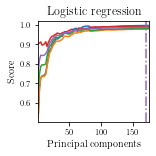

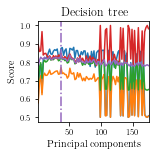

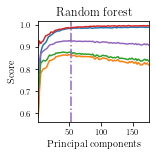

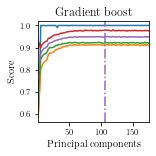

In [86]:
visualize.principalComponentsVSscores(X = trainingData.drop(["material_id", "full_formula"], axis=1),
                                     ModelsBestParams = ModelsBestParams,
                                     prettyNames = prettyNames,
                                     numPC = numberOfPrincipalComponents,
                                     approach = InsertApproach)

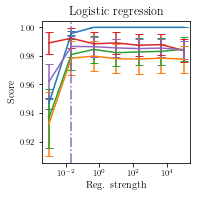

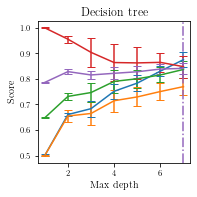

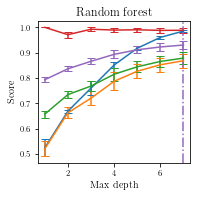

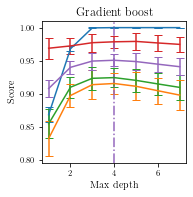

In [42]:
visualize.gridsearchVSscores(X = trainingData.drop(["material_id", "full_formula"], axis=1), 
                             ModelsBestParams = ModelsBestParams,
                            prettyNames = prettyNames,
                            approach = InsertApproach)

In [17]:
from IPython.display import display, Markdown

with open(Path.cwd().parent.parent.parent / "src" / "notebookcodesnippets" / "supervised" / "roc-auc.md", 'r') as fh:
    content = fh.read()

display(Markdown(content))
hide_toggle() 

## ROC-AUC and precision recall curves


0it [00:00, ?it/s]

Current training algorithm: LOG 


25it [02:12,  5.31s/it]


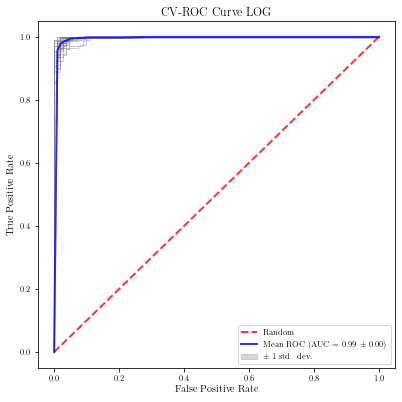

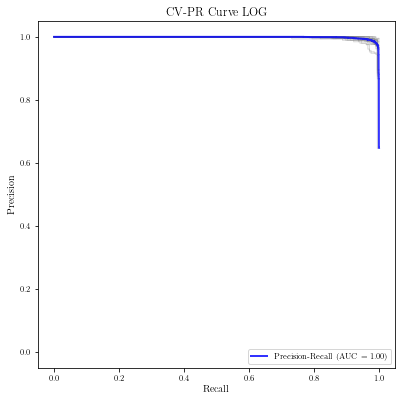

0it [00:00, ?it/s]

Mean accuracy:0.98140
Standard deviation:0.00998
f1-score:0.99267
Current training algorithm: DT 


25it [00:50,  2.03s/it]


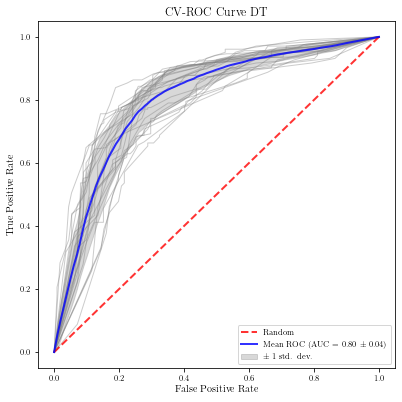

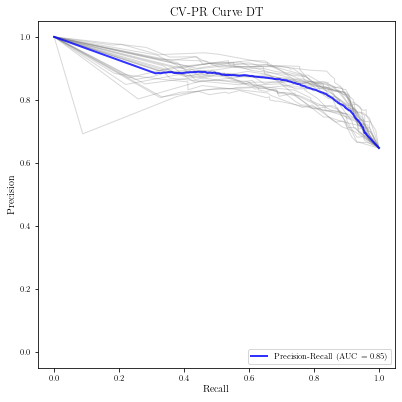

0it [00:00, ?it/s]

Mean accuracy:0.76939
Standard deviation:0.03633
f1-score:0.83663
Current training algorithm: RF 


25it [01:58,  4.75s/it]


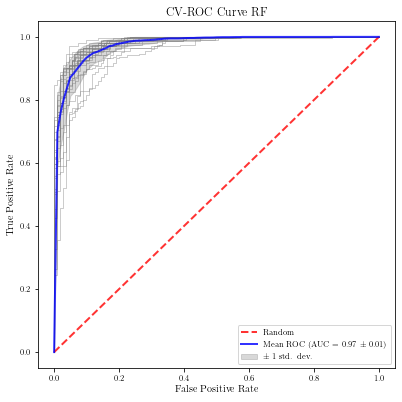

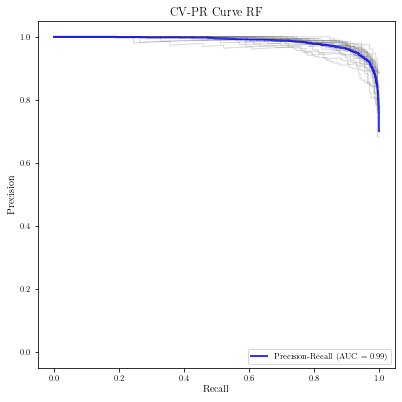

0it [00:00, ?it/s]

Mean accuracy:0.90032
Standard deviation:0.01934
f1-score:0.93953
Current training algorithm: GB 


25it [14:21, 34.47s/it]


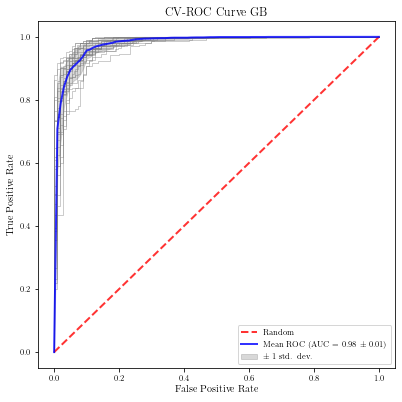

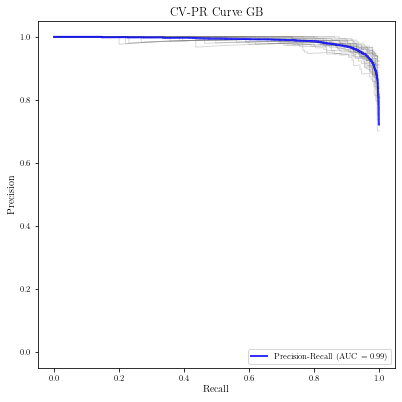

Mean accuracy:0.93144
Standard deviation:0.01672
f1-score:0.96190


In [18]:
SupervisedModels = pd.Series({}, dtype="string")

for i, algorithm in enumerate(Algorithms): 
    print("Current training algorithm: {}".format(prettyNames[i]))
    SupervisedModels[Abbreviations[i]] = (
        visualize.evaluatePrecisionRecallMetrics(classifier  = algorithm, 
                                     X = trainingData.drop(["material_id", "full_formula"], axis=1), 
                                     y = trainingTarget.values.reshape(-1,),
                                     k = numberSplits,
                                     n = numberRuns,
                                    cv = rskfold,
                     featureImportance = True,
                                 title = prettyNames[i],
                                 numPC = numberOfPrincipalComponents,
                              approach = InsertApproach )
    )

In [19]:
from IPython.display import display, Markdown

with open(Path.cwd().parent.parent.parent / "src" / "notebookcodesnippets" / "supervised" / "visualize-cv.md", 'r') as fh:
    content = fh.read()

display(Markdown(content))
hide_toggle()

# Visualizing the cross-validated trained models 


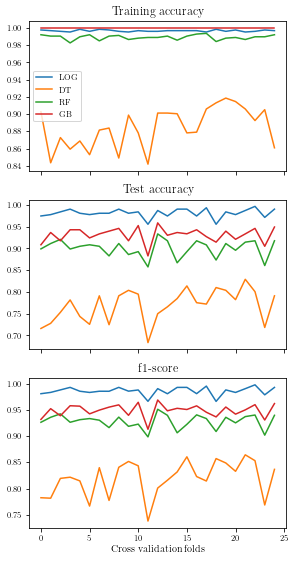

In [20]:
visualize.plot_accuracy(SupervisedModels, prettyNames,                                       
                     prettyNames = prettyNames,
                           numPC = numberOfPrincipalComponents,
                        approach = InsertApproach)

In [21]:
from IPython.display import display, Markdown

with open(Path.cwd().parent.parent.parent / "src" / "notebookcodesnippets" / "supervised" / "visualizerelevant.md", 'r') as fh:
    content = fh.read()

display(Markdown(content))
hide_toggle()

## Visualizing relevant features

Which features are the most important in predicting to give a label $0$ or $1$?


In [ ]:
visualize.plot_important_features(SupervisedModels,
                               X = trainingData.drop(["material_id", "full_formula"], axis=1),
                               k = numberSplits, 
                               n = numberRuns,                                      
                     prettyNames = prettyNames,
                           numPC = numberOfPrincipalComponents,
                        approach = InsertApproach)

In [23]:
from IPython.display import display, Markdown

with open(Path.cwd().parent.parent.parent / "src" / "notebookcodesnippets" / "supervised" / "falselypredicted.md", 'r') as fh:
    content = fh.read()

display(Markdown(content))
hide_toggle()

## Falsely predicted entries


In [24]:
visualize.plot_confusion_metrics(SupervisedModels, prettyNames, trainingData,
                                 k = numberSplits,
                                 n = numberRuns, 
                       prettyNames = prettyNames,
                             numPC = numberOfPrincipalComponents,
                          approach = InsertApproach)

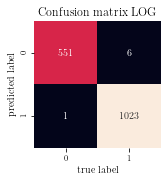

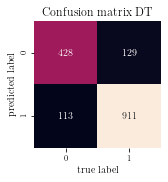

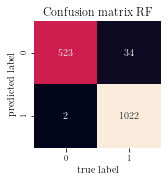

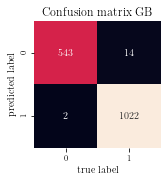

In [25]:
visualize.confusion_matrixQT(SupervisedModels, trainingTarget,                      
                             prettyNames = prettyNames,
                           numPC = numberOfPrincipalComponents,
                        approach = InsertApproach)

In [26]:
from IPython.display import display, Markdown

with open(Path.cwd().parent.parent.parent / "src" / "notebookcodesnippets" / "supervised" / "predictions.md", 'r') as fh:
    content = fh.read()

display(Markdown(content))
hide_toggle()

# Predicting solid-state qubit candidates

It is time to make the prediction based on the best estimators and features possible. The information of each optimal estimator is stored within the algorithm as pipeline objects. 


In [27]:
Summary                 = pd.DataFrame({}, dtype="string")
Summary["material_id"]  = testSet["material_id"]
Summary["full_formula"] = testSet["full_formula"]
Summary["pretty_formula"] = testSet["pretty_formula"]

PredictedCandidates = pd.Series({}, dtype="string")

threshold = numberSplits*numberRuns/2 #50% when equal
trainSet = trainingData.drop(["material_id", "full_formula"], axis=1)
testData = testSet.drop(["pretty_formula", "candidate", "full_formula", "material_id"], axis=1)
fittedAlgorithms = [] 

for i, algorithm in tqdm(enumerate(Algorithms)):
    
    # Train the final model with the best estimators
    fittedAlgorithm = train_model.fitAlgorithm(algorithm, 
                                    trainingData   = trainSet,#trainSet[trainSet.columns[SupervisedModels[Abbreviations[i]]["importantKeys"]>threshold]],\
                                    trainingTarget = trainingTarget.values.reshape(-1,),)
    
    fittedAlgorithms.append(fittedAlgorithm)
    
    # Predict the final model on unseen data
    PredictedCandidates[Abbreviations[i]],\
    PredictedCandidates[Abbreviations[i]+"Prob"] = predict_model.runPredictions(fittedAlgorithm,\
                                                        testData = testData)#[testData.columns[SupervisedModels[Abbreviations[i]]["importantKeys"]>threshold]])

4it [00:23,  5.94s/it]


In [28]:
for abbreviation in Abbreviations:
    Summary[abbreviation]            = PredictedCandidates[abbreviation]
    Summary[abbreviation + "Prob"]   = PredictedCandidates[abbreviation + "Prob"]
    print("{} predict the number of candidates as: {}".format(abbreviation, int(np.sum(PredictedCandidates[abbreviation]))))

LOG  predict the number of candidates as: 12380
DT  predict the number of candidates as: 11315
RF  predict the number of candidates as: 14278
GB  predict the number of candidates as: 11835


In [29]:
Summary

,material_id,full_formula,pretty_formula,LOG,LOG Prob,DT,DT Prob,RF,RF Prob,GB,GB Prob
1581,mvc-12905,Fe4O8,FeO2,1.0,0.597325,1.0,0.709677,1.0,0.630571,1.0,0.568050
1582,mp-24,C8,C,1.0,0.997700,1.0,1.000000,1.0,0.631594,1.0,0.635261
1583,mp-25,N8,N2,1.0,0.999925,1.0,1.000000,1.0,0.639430,1.0,0.867394
1584,mp-111,Ne1,Ne,1.0,1.000000,0.0,0.285714,1.0,0.725925,1.0,0.989346
1585,mp-118,P24,P,1.0,0.999405,1.0,0.944444,1.0,0.798340,1.0,0.906745
...,...,...,...,...,...,...,...,...,...,...,...
25199,mp-1304797,Sr12In4Ni4O24,Sr3InNiO6,1.0,0.963774,1.0,0.944444,1.0,0.822830,1.0,0.945229
25200,mp-1541522,Bi2P2O8,BiPO4,1.0,0.993755,1.0,0.937500,1.0,0.869584,1.0,0.985084
25201,mp-1541714,Cs3As2Cl9,Cs3As2Cl9,1.0,0.824289,0.0,0.099526,1.0,0.555974,1.0,0.656891
25202,mp-1542038,Cs2Sn2Se6,CsSnSe3,1.0,0.903751,1.0,0.941176,1.0,0.720311,1.0,0.912858


In [30]:
from IPython.display import display, Markdown

with open(Path.cwd().parent.parent.parent / "src" / "notebookcodesnippets" / "supervised" / "save.md", 'r') as fh:
    content = fh.read()

display(Markdown(content))
hide_toggle()

## Save the summary and models


In [31]:
file_path = Path(models_dir / InsertApproach / "trained-models")
Path(file_path).mkdir(parents=True, exist_ok=True)
for i, fitted_algorithm in tqdm(enumerate(fittedAlgorithms)):
    file_path = Path(models_dir / InsertApproach / "trained-models" / Path("PCA-" + str(numberOfPrincipalComponents) + "-" + prettyNames[i] + ".pkl"))
    with file_path.open("wb") as fp:
        pickle.dump(fitted_algorithm, fp)
        

file_path = (models_dir / InsertApproach /  "summary")
Path(Path(models_dir / InsertApproach /  "summary")).mkdir(parents=True, exist_ok=True)

file_path = Path(models_dir / InsertApproach /  "summary" / Path("PCA-" + str(numberOfPrincipalComponents) + "-" + "summary.pkl"))
with file_path.open("wb") as fp:
        pickle.dump(Summary, fp)

4it [00:00, 174.67it/s]
